# Import libraries

In [1]:
import datetime as datetime
from feature_extraction.indicator_features import *
from feature_extraction.daily_features import *  
import matplotlib.pyplot as plt
from model.model import *
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import pytse_client as tse
from pytse_client.download import download_financial_indexes
import seaborn as sns
from sklearn.model_selection import train_test_split
import ta
from zigzag import peak_valley_pivots

# Import data

In [2]:
tse.download(
    symbols = ['فولاد'],
    adjust = True, 
    write_to_csv = True, 
    include_jdate = True
)
folad = tse.Ticker(
    symbol = 'فولاد',  
    adjust = True
)
foladHist = folad.history
foladClient = folad.client_types

foladHist = foladHist[foladHist.columns[:-1].insert(0, foladHist.columns[-1]).to_list()] # change location of jdate

print(f'Shape of Folad price history: {foladHist.shape}')
print(f"Shape of Folad's client history: {foladClient.shape}")

Shape of Folad price history: (3451, 11)
Shape of Folad's client history: (3061, 18)


In [3]:
print(f'{foladHist.info()}')
foladHist.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3451 entries, 0 to 3450
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   jdate      3451 non-null   object        
 1   date       3451 non-null   datetime64[ns]
 2   open       3451 non-null   float64       
 3   high       3451 non-null   float64       
 4   low        3451 non-null   float64       
 5   adjClose   3451 non-null   float64       
 6   value      3451 non-null   int64         
 7   volume     3451 non-null   int64         
 8   count      3451 non-null   int64         
 9   yesterday  3451 non-null   float64       
 10  close      3451 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 296.7+ KB
None


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0
4,1385-12-26,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0


In [4]:
print(f'{foladClient.info()}')
foladClient.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3061 entries, 0 to 3060
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         3061 non-null   object 
 1   individual_buy_count         3061 non-null   object 
 2   corporate_buy_count          3061 non-null   object 
 3   individual_sell_count        3061 non-null   object 
 4   corporate_sell_count         3061 non-null   object 
 5   individual_buy_vol           3061 non-null   object 
 6   corporate_buy_vol            3061 non-null   object 
 7   individual_sell_vol          3061 non-null   object 
 8   corporate_sell_vol           3061 non-null   object 
 9   individual_buy_value         3061 non-null   object 
 10  corporate_buy_value          3061 non-null   object 
 11  individual_sell_value        3061 non-null   object 
 12  corporate_sell_value         3061 non-null   object 
 13  individual_buy_mea

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,20221106,3176,21,2586,22,112726579,41156292,146661680,7221191,557707552682,203802887179,725653102134,35857337727,4947.436156,4947.803013,4951.925387,4965.571154,-33935101.0
1,20221105,1783,14,2893,36,236470509,15618648,103524447,148564710,1162036617368,76842535119,506638347881,732240804606,4914.086844,4893.900548,4919.922334,4928.766762,132946062.0
2,20221102,1075,13,2241,16,33323175,80603446,93902133,20024488,153697495046,371518486400,432781118690,92434862756,4612.330459,4608.852907,4609.213437,4616.091196,-60578958.0
3,20221101,1484,11,1585,22,40392103,50632766,61698525,29326344,186269739244,233441235410,284615477066,135095497588,4611.538529,4613.002938,4610.477638,4606.625960,-21306422.0
4,20221031,1825,9,1708,21,49802410,67671193,70802783,46670820,226547677883,307828826912,321904919165,212471585630,4548.930019,4546.500936,4548.890204,4552.557372,-21000373.0


In [5]:
foladClient = foladClient.iloc[::-1]
foladClient.reset_index(
    drop = True,
    inplace = True
)
foladClient['date'] = foladClient['date'].apply(
    lambda x: datetime.datetime.strptime(x, '%Y%m%d')
)
foladClient.iloc[:, 1:] = foladClient.iloc[:, 1:].astype('float')

foladClient.head()

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,2008-11-26,14.0,2.0,4.0,1.0,106338.0,20010.0,126338.0,10.0,2.489373e+08,4.684412e+07,295757258.0,2.412000e+04,2341.000000,2341.0,2341.035482,2412.000000,-20000.0
1,2008-11-29,116.0,175.0,3.0,2.0,4718258.0,33691903.0,121402.0,38288759.0,1.498023e+10,1.077130e+11,284080680.0,1.224092e+11,3174.949168,2340.0,3196.999767,3196.999795,4596856.0
2,2008-11-30,10.0,2.0,1.0,1.0,87219.0,12791.0,100000.0,10.0,2.040052e+08,2.991886e+07,233900000.0,2.410000e+04,2339.000000,2339.0,2339.055508,2410.000000,-12781.0
3,2008-12-01,8.0,1.0,5.0,1.0,128666.0,10.0,128666.0,10.0,3.008211e+08,2.409000e+04,300821108.0,2.409000e+04,2338.000000,2338.0,2409.000000,2409.000000,0.0
4,2008-12-02,7.0,1.0,1.0,0.0,18553.0,10000.0,28553.0,0.0,4.335836e+07,2.337000e+07,66728361.0,0.000000e+00,2337.000000,2337.0,2337.000000,NaN,-10000.0


In [6]:
marketIndex = download_financial_indexes(
    symbols = 'شاخص كل', 
    write_to_csv = True
)
marketIndex = marketIndex['شاخص كل']
marketIndex.rename(
    columns = {'value': 'TEDPIX'}, 
    inplace = True
)

print(f'Shape of TEDPIX: {marketIndex.shape}')
marketIndex.head()

Shape of TEDPIX: (3362, 2)


,TEDPIX,date
0,9248.9,2008-12-04
1,9248.9,2008-12-05
2,9178.3,2008-12-06
3,9130.5,2008-12-07
4,9089.2,2008-12-08


In [7]:
foladHist = foladHist[foladHist.columns].merge(
    marketIndex, 
    how = 'left', 
    on = 'date'
)
foladHist.head()

,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,NaN
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,NaN
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,NaN
4,1385-12-26,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0,NaN


# Features

In [8]:
calCols = calender_features(foladHist)
candelCols = candlestick_feature(foladHist)
prpCols = prp_based(foladHist)
retCols = ret_based(foladHist)
shiftCols = shift_data(foladHist)
wghtCols = weight_feature(foladHist)

priceFeatures = pd.concat(
    [
        foladHist,
        calCols,
        candelCols,
        prpCols,
        retCols,
        shiftCols,
        wghtCols
    ], axis = 1
)

priceFeatures = priceFeatures.merge(
    indv_nonindv_features(foladClient),
    how = 'left',
    on = 'date'
)

print(f'Shape of price features: {priceFeatures.shape}')
priceFeatures.head()

Shape of price features: (3451, 121)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,month,quarter,day,weekday,shadow_up7d,shadow_low7d,body7d,shadow_up14d,shadow_low14d,body14d,shadow_up21d,shadow_low21d,body21d,shadow_up30d,shadow_low30d,body30d,shadow_up60d,shadow_low60d,body60d,shadow_up90d,shadow_low90d,body90d,max_price7d,min_price7d,ave_price7d,first_price7d,last_price7d,yesterday_price7d,max_price14d,min_price14d,first_price14d,last_price14d,yesterday_price14d,max_price21d,min_price21d,first_price21d,last_price21d,yesterday_price21d,max_price30d,min_price30d,first_price30d,last_price30d,yesterday_price30d,max_price60d,min_price60d,first_price60d,last_price60d,yesterday_price60d,max_price90d,min_price90d,first_price90d,last_price90d,yesterday_price90d,prp_high30d,prp_high60d,prp_high90d,prp_low30d,prp_low60d,prp_low90d,prp_value3d30d,prp_value5d60d,ret1d_log,ret3d_log,ret7d_log,ret14d_log,ret30d_log,ret60d_log,lastclose_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,value,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,enter_individual_money,individual_buy_per_capita,individual_sell_per_capita,individual_power,individual_power_3d,individual_power_5d,individual_power_10d,individual_power_20d,individual_power_prp_5d20
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN,1385,12,4,20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889437216900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,NaN,1385,12,4,21,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0,0,16.0,16.0,16.0,16.0,8.894372e+11,468077431.0,7736.0,16.0,16.0,NaN,193879458000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,NaN,1385,12,4,22,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0,0,16.0,16.0,16.0,16.0,1.938795e+11,100041000.0,9214.0,16.0,16.0,NaN,249241504527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,NaN,1385,12,4,23,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0,0,16.0,16.0,16.0,16.0,2.492415e+11,126270939.0,5862.0,16.0,16.0,NaN,51666379451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1385-12-26,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0,NaN,1385,12,4,26,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,16.0,NaN,16.0,16.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,

In [9]:
bbCols = BB(priceFeatures)
emaCols = EMA(foladHist)
macdCols = MACD(foladHist)
smaCols = SMA(foladHist)
stochasticCols = STOCHASTIC(foladHist)
rsiCols = RSI(foladHist)

indicatorFeatures = pd.concat(
    [
        bbCols,
        emaCols,
        macdCols,
        smaCols,
        stochasticCols,
        rsiCols,
    ], axis = 1
)

print(f'Shape of indicator features: {indicatorFeatures.shape}')
indicatorFeatures.head()

Shape of indicator features: (3451, 35)


,BB_bbh,BB_bbl,last_BB_bbh,last_BB_bbl,BB_buy,BB_position,EMA_5d,last_EMA_5d,EMA_40d,last_EMA_40d,EMA_buy,EMA_position,MACD,MACD_diff,MACD_signal,MACD_buy,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_buy,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_buy,STOCH_position,RSI,RSI_buy,RSI_position
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
features = pd.concat(
    [
        priceFeatures,
        indicatorFeatures
    ],
    axis = 1
)
print(f'shape of features after concatenation: {features.shape}')

features.dropna(
    axis = 'columns', 
    thresh = len(features) - 450,
    inplace = True
)
print(f'shape of features after drop non-essential columns: {features.shape}')
print(f'names of the columns that dropped: {(indicatorFeatures.columns.union(priceFeatures.columns)).difference(features.columns).to_list()}')

features.dropna(
    axis = 'index', 
    how = 'any',
    inplace = True
)
print(f'shape of features after drop non-essential rows: {features.shape}')

features.head()

shape of features after concatenation: (3451, 156)
shape of features after drop non-essential columns: (3451, 150)
names of the columns that dropped: ['BB_buy', 'EMA_buy', 'MACD_buy', 'RSI_buy', 'SMA_buy', 'STOCH_buy']
shape of features after drop non-essential rows: (2917, 150)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,month,quarter,day,weekday,shadow_up7d,shadow_low7d,body7d,shadow_up14d,shadow_low14d,body14d,shadow_up21d,shadow_low21d,body21d,shadow_up30d,shadow_low30d,body30d,shadow_up60d,shadow_low60d,body60d,shadow_up90d,shadow_low90d,body90d,max_price7d,min_price7d,ave_price7d,first_price7d,last_price7d,yesterday_price7d,max_price14d,min_price14d,first_price14d,last_price14d,yesterday_price14d,max_price21d,min_price21d,first_price21d,last_price21d,yesterday_price21d,max_price30d,min_price30d,first_price30d,last_price30d,yesterday_price30d,max_price60d,min_price60d,first_price60d,last_price60d,yesterday_price60d,max_price90d,min_price90d,first_price90d,last_price90d,yesterday_price90d,prp_high30d,prp_high60d,prp_high90d,prp_low30d,prp_low60d,prp_low90d,prp_value3d30d,prp_value5d60d,ret1d_log,ret3d_log,ret7d_log,ret14d_log,ret30d_log,ret60d_log,lastclose_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,value,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,enter_individual_money,individual_buy_per_capita,individual_sell_per_capita,individual_power,individual_power_3d,individual_power_5d,individual_power_10d,individual_power_20d,individual_power_prp_5d20,BB_bbh,BB_bbl,last_BB_bbh,last_BB_bbl,BB_position,EMA_5d,last_EMA_5d,EMA_40d,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position
449,1388-02-15,2009-05-05,15.0,15.0,15.0,15.0,1081376640,586112,41,15.0,15.0,8699.5,1388,2,1,15,3,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0,-0.066667,0.0000,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0625,-0.0625,0.0625,15.0,14.0,15.214286,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,17.0,14.0,16.0,15.0,16.0,1.000000,0.882353,0.882353,1.071429,1.071429,1.071429,1.041980,0.759095,0.000000,0.000000,0.000000,0.000000,0.000000,-0.125163,0.000000,0,0,14.0,15.0,14.0,15.0,3.759837e+09,2080737.0,204.0,15.0,15.0,8638.3,1081376640,3.059118e+09,2.310900e+09,2.418149e+09,2.313320e+09,2.470778e+09,3.837590e+09,3.865225e+09,4.283519e+09,4.586396e+09,3.059118e+09,2.310900e+09,2.418149e+09,2.313320e+09,2.470778e+09,3.837590e+09,3.865225e+09,4.283519e+09,4.586396e+09,2.605398e+08,6.939266e+07,3.095620e+07,2.241640,1.751292,2.161544,2.610384,1.299605,0.601239,15.000003,14.999997,15.000003,14.999997,1.0,14.999965,14.999948,15.117827,15.123870,0.0,0.003671,0.011510,-0.007839,1.0,15.0,15.0,15.0,14.833333,14.96,14.98,15.4625,0.0,100.0,80.0,100.0,80.0,1.0,49.815169,1.0
450,1388-02-16,2009-05-06,15.0,15.0,15.0,15.0,91486200,49452,11,15.0,15.0,8774.2,1388,2,1,16,4,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0,-0.066667,0.0000,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0625,-0.0625,0.0625,15.0,14.0,15.200000,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,17.0,14.0,16.0,15.0,16.0,1.000000,0.882353,0.882353,1.071429,1.071429,1.071429,0.729210,0.722844,0.000000,0.000000,0.000000,0.000000,0.068993,-0.125163,0.000000,0,0,15.0,15.0,15.0,15.0,1.081377e+09,586112.0,41.0,15.0,15.0,8699.5,91486200,3.039489e+09,2.254816e+09,2.418696e+09,2.299024e+09,2.338820e+09,3.783634e+09,3.790551e+09,4.222707e+09,4.584972e+09,3.039489e+09,2.254816e+09,2.418696e+09,2.299024e+09,2.338820e+09,3.783634e+09,3.790551e+09,4.222707e+09,4.584972e+09,0.000000e+00,9.148620e+07,9.148620e+06,10.000000,2.205688,3.506739,5.561177,5.004484,1.427105,15.000003,14.999997,15.000003,14.999997,1.0,14.999977,14.999965,15.112079,15.117827,0.0,0.004086,0.009540,-0.005454,1.0,

In [11]:
peak_valley_pivots(
    foladHist['adjClose'], 
    0.075, 
    -0.075
) * -1

array([-1,  0,  0, ...,  0,  0, -1])

In [12]:
pivots = pd.DataFrame(
    peak_valley_pivots(
        foladHist['adjClose'], 
        0.075, 
        -0.075
    ) * -1,
    columns = ['label']
)
signals = pivots.replace(
    to_replace = 0, 
    value = np.nan
)
signals.fillna(
    method = 'ffill', 
    inplace = True
)
# signals.replace(
#     to_replace = -1, 
#     value = 0,  
#     inplace = True
# )
pivots.columns = ['pivots']
signals['date'] = foladHist['date']
pivots['date'] = foladHist['date']

print(f'Number of each class {np.unique(signals["label"], return_counts = True)}')

Number of each class (array([-1.,  1.]), array([1556, 1895], dtype=int64))


In [13]:
initFeatures = features.merge(
    signals,
    how = 'left',
    on = 'date'
)

initFeatures.to_csv(
    'initFeatures.csv', 
    index = False
)

print(f'Number of initial features: {initFeatures.shape}')
initFeatures

Number of initial features: (2917, 151)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,month,quarter,day,weekday,shadow_up7d,shadow_low7d,body7d,shadow_up14d,shadow_low14d,body14d,shadow_up21d,shadow_low21d,body21d,shadow_up30d,shadow_low30d,body30d,shadow_up60d,shadow_low60d,body60d,shadow_up90d,shadow_low90d,body90d,max_price7d,min_price7d,ave_price7d,first_price7d,last_price7d,yesterday_price7d,max_price14d,min_price14d,first_price14d,last_price14d,yesterday_price14d,max_price21d,min_price21d,first_price21d,last_price21d,yesterday_price21d,max_price30d,min_price30d,first_price30d,last_price30d,yesterday_price30d,max_price60d,min_price60d,first_price60d,last_price60d,yesterday_price60d,max_price90d,min_price90d,first_price90d,last_price90d,yesterday_price90d,prp_high30d,prp_high60d,prp_high90d,prp_low30d,prp_low60d,prp_low90d,prp_value3d30d,prp_value5d60d,ret1d_log,ret3d_log,ret7d_log,ret14d_log,ret30d_log,ret60d_log,lastclose_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,value,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,enter_individual_money,individual_buy_per_capita,individual_sell_per_capita,individual_power,individual_power_3d,individual_power_5d,individual_power_10d,individual_power_20d,individual_power_prp_5d20,BB_bbh,BB_bbl,last_BB_bbh,last_BB_bbl,BB_position,EMA_5d,last_EMA_5d,EMA_40d,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,label
0,1388-02-15,2009-05-05,15.0,15.0,15.0,15.0,1081376640,586112,41,15.0,15.0,8699.5,1388,2,1,15,3,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.062500,-0.062500,0.062500,15.0,14.0,15.214286,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,17.0,14.0,16.0,15.0,16.0,1.000000,0.882353,0.882353,1.071429,1.071429,1.071429,1.041980,0.759095,0.000000,0.000000,0.000000,0.000000,0.000000,-0.125163,0.000000,0,0,14.0,15.0,14.0,15.0,3.759837e+09,2080737.0,204.0,15.0,15.0,8638.3,1081376640,3.059118e+09,2.310900e+09,2.418149e+09,2.313320e+09,2.470778e+09,3.837590e+09,3.865225e+09,4.283519e+09,4.586396e+09,3.059118e+09,2.310900e+09,2.418149e+09,2.313320e+09,2.470778e+09,3.837590e+09,3.865225e+09,4.283519e+09,4.586396e+09,2.605398e+08,6.939266e+07,3.095620e+07,2.241640,1.751292,2.161544,2.610384,1.299605,0.601239,15.000003,14.999997,15.000003,14.999997,1.0,14.999965,14.999948,15.117827,15.123870,0.0,0.003671,0.011510,-0.007839,1.0,15.0,15.00,15.00,14.833333,14.96,14.98,15.4625,0.0,100.000000,80.000000,100.000000,80.000000,1.0,49.815169,1.0,1.0
1,1388-02-16,2009-05-06,15.0,15.0,15.0,15.0,91486200,49452,11,15.0,15.0,8774.2,1388,2,1,16,4,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.062500,-0.062500,0.062500,15.0,14.0,15.200000,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,17.0,14.0,16.0,15.0,16.0,1.000000,0.882353,0.882353,1.071429,1.071429,1.071429,0.729210,0.722844,0.000000,0.000000,0.000000,0.000000,0.068993,-0.125163,0.000000,0,0,15.0,15.0,15.0,15.0,1.081377e+09,586112.0,41.0,15.0,15.0,8699.5,91486200,3.039489e+09,2.254816e+09,2.418696e+09,2.299024e+09,2.338820e+09,3.783634e+09,3.790551e+09,4.222707e+09,4.584972e+09,3.039489e+09,2.254816e+09,2.418696e+09,2.299024e+09,2.338820e+09,3.783634e+09,3.790551e+09,4.222707e+09,4.584972e+09,0.000000e+00,9.148620e+07,9.148620e+06,10.000000,2.205688,3.506739,5.561177,5.004484,1.427105,15.000003,14.999997,15.000

# Model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    initFeatures.iloc[:, 2:-1].values, 
    initFeatures.iloc[:, -1].values, 
    shuffle = False, 
    random_state = 0
)

In [16]:
trainPred, testPred, trainProb, testProb, featureImport, trainClassReport,\
    testClassReport = RFClf(X_train, y_train, X_test, y_test)

print(f'Training classification report:\n{trainClassReport}')
print(f'Testing classification report:\n{testClassReport}')

Training classification report:
              precision    recall  f1-score   support

        -1.0       0.81      0.86      0.83      1025
         1.0       0.87      0.82      0.84      1162

    accuracy                           0.84      2187
   macro avg       0.84      0.84      0.84      2187
weighted avg       0.84      0.84      0.84      2187

Testing classification report:
              precision    recall  f1-score   support

        -1.0       0.74      0.75      0.74       357
         1.0       0.75      0.75      0.75       373

    accuracy                           0.75       730
   macro avg       0.75      0.75      0.75       730
weighted avg       0.75      0.75      0.75       730



In [17]:
def convertLabel(df, colName):
    name = str(colName + '01')
    df.loc[initFeatures[colName] == -1, name] = 0
    df[name] = df[name].fillna(1)
    return df
    
initFeatures['priChange'] = initFeatures['adjClose'] - initFeatures['yesterday']
labelPred = np.concatenate((trainPred, testPred), axis = 0)
initFeatures['labelPred'] = labelPred

initFeatures = convertLabel(initFeatures, 'label')
initFeatures = convertLabel(initFeatures, 'labelPred')

initFeatures = initFeatures.merge(
    pivots,
    how = 'left',
    on = 'date'
)

initFeatures.head()

,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,month,quarter,day,weekday,shadow_up7d,shadow_low7d,body7d,shadow_up14d,shadow_low14d,body14d,shadow_up21d,shadow_low21d,body21d,shadow_up30d,shadow_low30d,body30d,shadow_up60d,shadow_low60d,body60d,shadow_up90d,shadow_low90d,body90d,max_price7d,min_price7d,ave_price7d,first_price7d,last_price7d,yesterday_price7d,max_price14d,min_price14d,first_price14d,last_price14d,yesterday_price14d,max_price21d,min_price21d,first_price21d,last_price21d,yesterday_price21d,max_price30d,min_price30d,first_price30d,last_price30d,yesterday_price30d,max_price60d,min_price60d,first_price60d,last_price60d,yesterday_price60d,max_price90d,min_price90d,first_price90d,last_price90d,yesterday_price90d,prp_high30d,prp_high60d,prp_high90d,prp_low30d,prp_low60d,prp_low90d,prp_value3d30d,prp_value5d60d,ret1d_log,ret3d_log,ret7d_log,ret14d_log,ret30d_log,ret60d_log,lastclose_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,value,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,enter_individual_money,individual_buy_per_capita,individual_sell_per_capita,individual_power,individual_power_3d,individual_power_5d,individual_power_10d,individual_power_20d,individual_power_prp_5d20,BB_bbh,BB_bbl,last_BB_bbh,last_BB_bbl,BB_position,EMA_5d,last_EMA_5d,EMA_40d,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,label,priChange,labelPred,label01,labelPred01,pivots
0,1388-02-15,2009-05-05,15.0,15.0,15.0,15.0,1081376640,586112,41,15.0,15.0,8699.5,1388,2,1,15,3,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0,-0.066667,0.0000,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0625,-0.0625,0.0625,15.0,14.0,15.214286,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,17.0,14.0,16.0,15.0,16.0,1.000000,0.882353,0.882353,1.071429,1.071429,1.071429,1.041980,0.759095,0.000000,0.000000,0.000000,0.000000,0.000000,-0.125163,0.000000,0,0,14.0,15.0,14.0,15.0,3.759837e+09,2080737.0,204.0,15.0,15.0,8638.3,1081376640,3.059118e+09,2.310900e+09,2.418149e+09,2.313320e+09,2.470778e+09,3.837590e+09,3.865225e+09,4.283519e+09,4.586396e+09,3.059118e+09,2.310900e+09,2.418149e+09,2.313320e+09,2.470778e+09,3.837590e+09,3.865225e+09,4.283519e+09,4.586396e+09,2.605398e+08,6.939266e+07,3.095620e+07,2.241640,1.751292,2.161544,2.610384,1.299605,0.601239,15.000003,14.999997,15.000003,14.999997,1.0,14.999965,14.999948,15.117827,15.123870,0.0,0.003671,0.011510,-0.007839,1.0,15.0,15.0,15.0,14.833333,14.96,14.98,15.4625,0.0,100.0,80.0,100.0,80.0,1.0,49.815169,1.0,1.0,0.0,1.0,1.0,1.0,0
1,1388-02-16,2009-05-06,15.0,15.0,15.0,15.0,91486200,49452,11,15.0,15.0,8774.2,1388,2,1,16,4,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0,-0.066667,0.0000,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0625,-0.0625,0.0625,15.0,14.0,15.200000,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,17.0,14.0,16.0,15.0,16.0,1.000000,0.882353,0.882353,1.071429,1.071429,1.071429,0.729210,0.722844,0.000000,0.000000,0.000000,0.000000,0.068993,-0.125163,0.000000,0,0,15.0,15.0,15.0,15.0,1.081377e+09,586112.0,41.0,15.0,15.0,8699.5,91486200,3.039489e+09,2.254816e+09,2.418696e+09,2.299024e+09,2.338820e+09,3.783634e+09,3.790551e+09,4.222707e+09,4.584972e+09,3.039489e+09,2.254816e+09,2.418696e+09,2.299024e+09,2.338820e+09,3.783634e+09,3.790551e+09,4.222707e+09,4.584972e+09,0.000000e+00,9.148620e+07,9.148620e+06,10.000000,2.205688,3.506739,5.561177,5.004484,1.427105,15.000003,14.999997,15.000003,14.999997,1.0,14.99

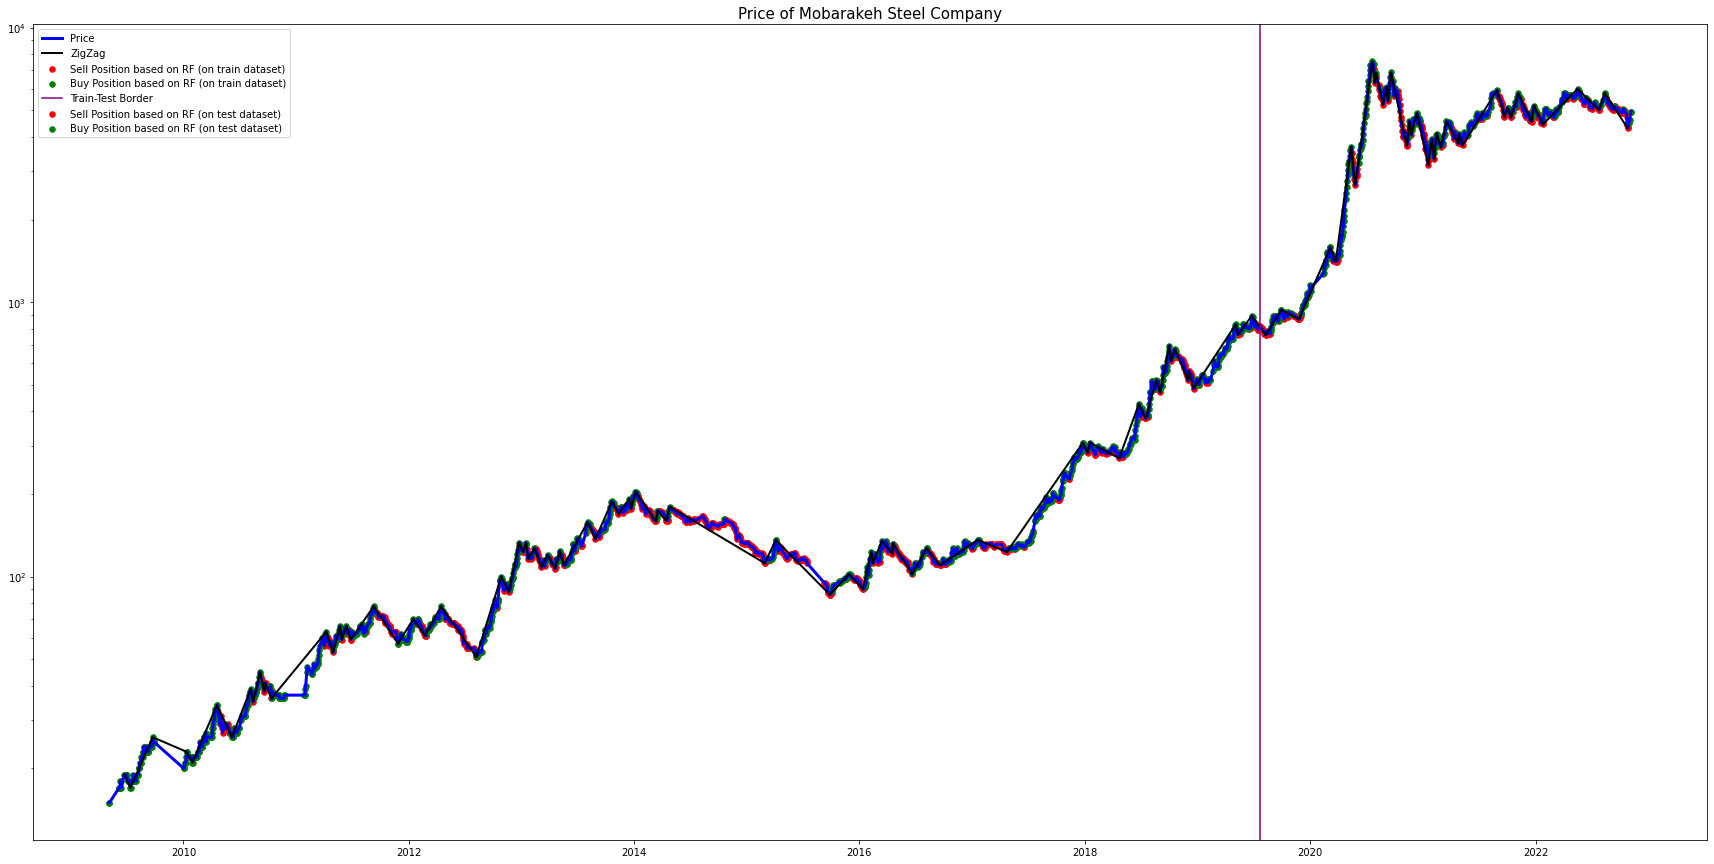

In [18]:
def plotLabel(df, trainPred, testPred):
    
    date = df['date']
    price = df['adjClose']
    label = df['label']
    neutralIndex = df['pivots'] == 0
    trainBuy = df.loc[df.index < len(trainPred)].loc[trainPred == 1].index 
    trainSell = df.loc[df.index < len(trainPred)].loc[trainPred == -1].index
    trainTestBorder = df.loc[df.index == len(trainPred)].index
    testBuy = df.loc[df.index >= len(trainPred)].loc[testPred == 1].index 
    testSell = df.loc[df.index >= len(trainPred)].loc[testPred == -1].index 
    
    plt.figure(figsize = (30, 15))
    plt.title('Price of Mobarakeh Steel Company', fontsize = 15)
    plt.plot(
        date,
        price,
        color = 'blue',
        lw = 3,
        label = 'Price'
    )    
    plt.plot(
        date.iloc[np.where(~neutralIndex)], 
        price.iloc[np.where(~neutralIndex)],
        color = 'black',
        lw = 2,
        label = 'ZigZag'
    )


    # train
    plt.scatter(
        date.iloc[trainSell] , 
        price.iloc[trainSell],
        color = 'red',
        s = 30,
        label = 'Sell Position based on RF (on train dataset)'
    )
    plt.scatter(
        date.iloc[trainBuy], 
        price.iloc[trainBuy],
        color = 'green',
        s = 30,
        label = 'Buy Position based on RF (on train dataset)'
    )
    plt.yscale('log')

    plt.axvline(date.iloc[trainTestBorder], color = 'purple', label = 'Train-Test Border')

    # test
    plt.scatter(
        date.iloc[testSell] , 
        price.iloc[testSell],
        color = 'red',
        s = 30,
        label = 'Sell Position based on RF (on test dataset)'
    )
    plt.scatter(
        date.iloc[testBuy], 
        price.iloc[testBuy],
        color = 'green',
        s = 30,
        label = 'Buy Position based on RF (on test dataset)'
    )
    plt.yscale('log')
    plt.legend()

plotLabel(initFeatures, trainPred, testPred)

In [19]:
print(f'Return in passive invesitng in train section: {(initFeatures["adjClose"].iloc[len(trainPred) - 1]  / initFeatures["adjClose"].iloc[0]):0.0%}')
print(f'Return in passive invesitng in test section: {(initFeatures["adjClose"].iloc[-1]  / initFeatures["adjClose"].iloc[len(trainPred)]):0.0%}')

print(f'Max return in train section based on zigzag: {((initFeatures["priChange"] * initFeatures["label01"].shift(2)).iloc[:len(trainPred)].sum() / initFeatures["adjClose"].iloc[0]):0.0%}')
print(f'Max return in test section based on zigzag: {((initFeatures["priChange"] * initFeatures["label01"].shift(2)).iloc[len(trainPred):].sum() / initFeatures["adjClose"].iloc[len(trainPred)]):0.0%}')

print(f'Return in train section based on prediction: {((initFeatures["priChange"] * initFeatures["labelPred01"].shift(2)).iloc[:len(trainPred)].sum() / initFeatures["adjClose"].iloc[0]):0.0%}')
print(f'Return in test section based on prediction: {((initFeatures["priChange"] * initFeatures["labelPred01"].shift(2)).iloc[len(trainPred):].sum() / initFeatures["adjClose"].iloc[len(trainPred)]):0.0%}')

Return in passive invesitng in train section: 5287%
Return in passive invesitng in test section: 602%
Max return in train section based on zigzag: 11040%
Max return in test section based on zigzag: 2171%
Return in train section based on prediction: 5467%
Return in test section based on prediction: 719%


# Bayesian Optimization

In [ ]:
# def rfcScore(
#     n_estimators,
#     min_samples_split,
#     min_samples_leaf,
#     max_depth):
    
#     n_estimators = int(n_estimators)
#     min_samples_split = int(min_samples_split)
#     min_samples_leaf = int(min_samples_leaf)
#     max_depth = int(max_depth)
    
#     params = {
#         'n_estimators': n_estimators,
#         'criterion': 'entropy',
#         'min_samples_split': min_samples_split,
#         'min_samples_leaf': min_samples_leaf,
#         'max_depth': max_depth,
#         'max_features': 'sqrt',
#         'n_jobs': -1,
#         'random_state': 1,
#         'class_weight': 'balanced_subsample'
#     }

#     rfc = RandomForestClassifier(
#         **params
#     )

#     score = cross_val_score(
#         rfc, 
#         X = X_train,
#         y = y_train,
#         scoring = 'f1_weighted'
#     ).mean()

#     return score

# def RFClf(train_data, train_label, test_data, test_label, params):
    
#     clf = RandomForestClassifier(
#         n_estimators = int(params['n_estimators']),
#         max_depth = int(params['max_depth']),
#         min_samples_leaf = int(params['min_samples_leaf']),
#         min_samples_split = int(params['min_samples_split']),
#         criterion = 'entropy',
#         class_weight = 'balanced_subsample',
#         random_state = 0
#     )

#     clf.fit(train_data, train_label)
    
#     trainPred = clf.predict(train_data)
#     testPred = clf.predict(test_data)

#     trainProb = clf.predict_proba(train_data)
#     testProb = clf.predict_proba(test_data)

#     featureImport = clf.feature_importances_

#     trainClassReport = metrics.classification_report(train_label, trainPred)
#     testClassReport = metrics.classification_report(test_label, testPred)

#     return trainPred, testPred, trainProb, testProb, featureImport, trainClassReport, testClassReport

# rfcBound = {
#     'n_estimators': (100, 200),
#     'min_samples_split': (2, 5),
#     'min_samples_leaf': (1, 5),
#     'max_depth': (4, 8)
# }
# optimizer = BayesianOptimization(
#     f = rfcScore, 
#     pbounds = rfcBound,
#     random_state = 1
# )
# optimizer.maximize(
#     init_points = 3,
#     n_iter = 5,
# )

# print(f"Selected parameters: {optimizer.max['params']}\n")

# trainPred, testPred, trainProb, testProb, featureImport, trainClassReport, testClassReport = RFClf(X_train, y_train, X_test, y_test, optimizer.max['params'])

# print(f'Training classification report:\n{trainClassReport}')
# print(f'Testing classification report:\n{testClassReport}')